# Data Analysis for RQ1, based on riot API data

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Define file paths for each rank
file_path = "data/riot_API/"
rank_paths = {
    "IRON": os.path.join(file_path, "matchup_data_IRON.csv"),
    "BRONZE": os.path.join(file_path, "matchup_data_BRONZE.csv"),
    "SILVER": os.path.join(file_path, "matchup_data_SILVER.csv"),
    "GOLD": os.path.join(file_path, "matchup_data_GOLD.csv"),
    "PLATINUM": os.path.join(file_path, "matchup_data_PLATINUM.csv"),
    "EMERALD": os.path.join(file_path, "matchup_data_EMERALD.csv"),
    "DIAMOND": os.path.join(file_path, "matchup_data_DIMOND.csv")
}

# Load data into a dictionary of DataFrames
dataframes = {tier: pd.read_csv(path) for tier, path in rank_paths.items()}

## data summary

In [3]:
# List to collect benchmark results
benchmark_data = []

# Standard gold per creep
GOLD_PER_CS = 20

# Process each DataFrame
for tier, df in dataframes.items():
    # Compute average CS at 10 minutes
    avg_cs10 = df['first_10_min_cs'].mean()

    # Estimate player's total gold using standard 20 gold per creep
    avg_gold = (df['first_10_min_cs'] * GOLD_PER_CS).mean()

    benchmark_data.append({
        'Tier': tier.capitalize(),
        'API Avg CS@10': avg_cs10,
        'API Avg Gold': avg_gold
    })

# Convert results to DataFrame
benchmark_df = pd.DataFrame(benchmark_data)

# Optional: sort by average CS@10 for clearer presentation
benchmark_df = benchmark_df.sort_values(by='API Avg CS@10')

# Display the result
print(benchmark_df)


       Tier  API Avg CS@10  API Avg Gold
0      Iron      57.250128   1145.002552
1    Bronze      60.020936   1200.418719
2    Silver      61.283593   1225.671860
3      Gold      63.976307   1279.526136
4  Platinum      65.325087   1306.501749
5   Emerald      67.374749   1347.494990
6   Diamond      67.992372   1359.847445


In [4]:
# Tier groupings
tier_groups = {
    "Beginner": ["IRON", "BRONZE", "SILVER"],
    "Intermediate": ["GOLD", "PLATINUM"],
    "High": ["EMERALD", "DIAMOND"]
}

# Compute stats for each group
group_stats = []

for group, tiers in tier_groups.items():
    combined_df = pd.concat([dataframes[tier] for tier in tiers], ignore_index=True)
    avg_cs = combined_df['total_cs'].mean()
    avg_gold = (combined_df['total_cs'] * GOLD_PER_CS).mean()
    
    group_stats.append({
        "Group": group,
        "Average Total CS": avg_cs,
        "Average Gold Earned": avg_gold
    })

# Convert to DataFrame
summary_df = pd.DataFrame(group_stats)

summary_df

,Group,Average Total CS,Average Gold Earned
0,Beginner,179.493464,3589.869270
1,Intermediate,192.349926,3846.998518
2,High,189.401689,3788.033781


C:\Users\hanxiao\AppData\Local\Temp\ipykernel_52920\3960222895.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="Tier", y="cs_per_min", data=df_all, palette="bright")


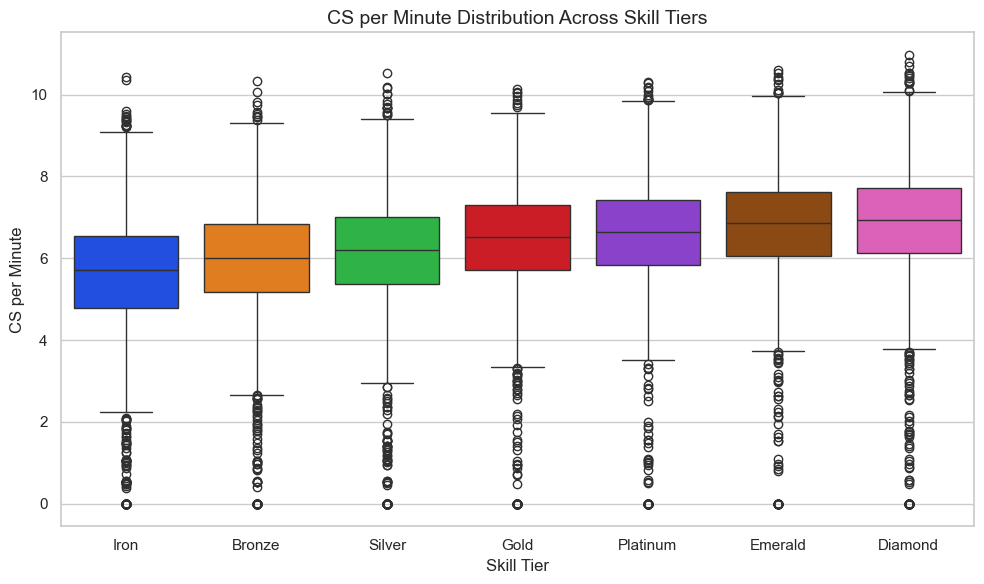

In [5]:
combined_data = []
for tier, df in dataframes.items():
    temp_df = df.copy()
    temp_df["Tier"] = tier.capitalize()
    combined_data.append(temp_df)

df_all = pd.concat(combined_data, ignore_index=True)

# Plot settings
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Create boxplot
ax = sns.boxplot(x="Tier", y="cs_per_min", data=df_all, palette="bright")

# Customize appearance
ax.set_title("CS per Minute Distribution Across Skill Tiers", fontsize=14)
ax.set_xlabel("Skill Tier", fontsize=12)
ax.set_ylabel("CS per Minute", fontsize=12)

# Save to file (for use in LaTeX or reports)
plt.tight_layout()
plt.savefig("cs_per_min_distribution.png", dpi=300)

# Display the plot
plt.show()

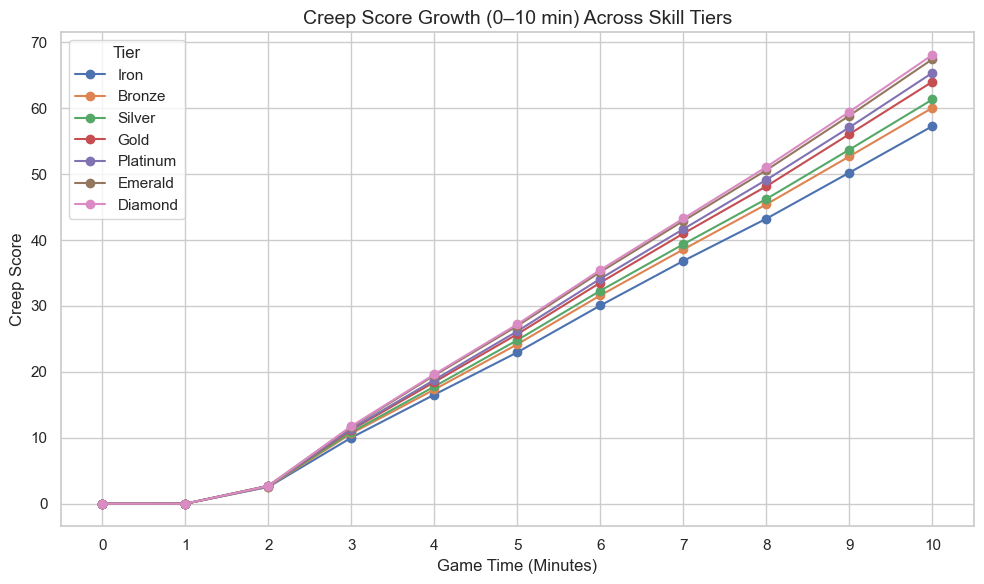

In [6]:
cs_timeline_by_tier = {}

# Process each tier
for tier, df in dataframes.items():
    tier_name = tier.capitalize()

    # Extract CS timeline and keep only first 10 minutes
    cs_lists = df['player_cs_timeline'].dropna().apply(
        lambda x: list(map(int, x.split(',')))[:11]  # minute 0–10
    )

    # Pad shorter sequences with last known value
    max_len = 11
    cs_matrix = np.array([
        cs + [cs[-1]] * (max_len - len(cs)) if len(cs) > 0 else [0] * max_len
        for cs in cs_lists
    ])

    avg_cs_timeline = np.mean(cs_matrix, axis=0)

    cs_timeline_by_tier[tier_name] = avg_cs_timeline

# === Plotting ===
plt.figure(figsize=(10, 6))
x = list(range(0, 11))  # Minutes 0–10

for tier, gold in cs_timeline_by_tier.items():
    plt.plot(x, gold, marker='o', label=tier)  # add markers

plt.title("Creep Score Growth (0–10 min) Across Skill Tiers", fontsize=14)
plt.xlabel("Game Time (Minutes)", fontsize=12)
plt.ylabel("Creep Score", fontsize=12)
plt.xticks(x)  # show each minute explicitly
plt.legend(title="Tier")
plt.grid(True)
plt.tight_layout()

# Save to file
plt.savefig("gold_accumulation_0_10min_points.png", dpi=300)

# Show plot
plt.show()